In [3]:
import mne
import matlab.engine
import numpy as np
import pandas as pd
import pylab as plt

# For custom codebase
import sys
sys.path.insert(0, 'C:\\Users\\esolo\\Documents\\Python Scripts\\lib')
from codebase import matlabToPython

# For parallel processing
import multiprocessing as mp
n_cpus = mp.cpu_count()

In [19]:
#Load the data
fname = './TMSEEG_data/477/477_Sham_TMS_Sham_Parietal_0_5Hz_1-Cleaned.mat'

eng = matlab.engine.start_matlab()  #start the MATLAB engine
content = eng.load(fname, nargout=1)
elecs = matlabToPython(eng, content, 'channelInfo')  #Import from .mat files -- does appear that channelInfo is the same between sham/TMS trials but always good to double check

In [20]:
#Load sham/TMS times -- best handled manually on a per-subject basis given formatting heterogeneity
trigTimes = np.array(content['trigTimes'])[0]

#Load EEG data
eeg = np.array(content['ftData']['trial'][0])

shambool = (trigTimes<135) | (trigTimes>260)
#shambool = trigTimes<115
#tmsbool = (trigTimes>115) & (trigTimes<375)
#tmsbool = ((trigTimes>115) & (trigTimes<375)) | (trigTimes>420)
#shambool = (trigTimes<200) | (trigTimes>333)
tmsbool = ~shambool

trigTimes_sham = trigTimes[shambool]
trigTimes_tms = trigTimes[tmsbool]

#figure out downsample factor
fs = 500
dsample = int(content['ftData']['fsample']/fs) 

In [7]:
# Filter out line noise
eeg_filt = mne.filter.notch_filter(eeg, Fs=content['ftData']['fsample'], freqs=[60, 120, 180],
                                    method='spectrum_fit', n_jobs=n_cpus, verbose=False)

# Resample the data (should we do this before or after filtering line noise -- better to do AFTER but is more comp intensive)
eeg_rs =  mne.filter.resample(eeg_filt, down=dsample, n_jobs=n_cpus)

#Low-pass filter for the ERP analysis, not spectral (optional)
#eeg_filt_lp = mne.filter.filter_data(eeg_rs, sfreq=fs, l_freq=None, h_freq=35, verbose=False, n_jobs=n_cpus)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done  64 tasks      | elapsed:   19.2s
[Parallel(n_jobs=8)]: Done 154 tasks      | elapsed:   43.7s
[Parallel(n_jobs=8)]: Done 209 out of 209 | elapsed:   57.9s finished


In [14]:
# Convert trigTimes to samples
trigTimes_sham_samp = (trigTimes_sham*fs).astype(int)
trigTimes_tms_samp = (trigTimes_tms*fs).astype(int)

#Plot triggered evoked potential
sep_sham = []
for idx in trigTimes_sham_samp:
    sep_sham.append(eeg_rs[:, int(idx-(fs/2)):int(idx+(fs*2))])  #getting 500ms prior to stim until 2 seconds after stim
sep_sham = np.array(sep_sham)

sep_tms = []
for idx in trigTimes_tms_samp:
    sep_tms.append(eeg_rs[:, int(idx-(fs/2)):int(idx+(fs*2))])
sep_tms = np.array(sep_tms)

In [9]:
#Save the filtered and resampled data
#np.save('./TMSEEG_data/483/483_Sham_DLPFC_0_5Hz_1-CleanedFilteredSubsampled.npy', sep_sham)
#np.save('./TMSEEG_data/483/483_TMS_DLPFC_0_5Hz_1-CleanedFilteredSubsampled.npy', sep_tms)

#elecs.to_pickle('./TMSEEG_data/483/483_DLPFC_elecs.pkl')

## Get stimulation evoked potentials (SEPs)

In [26]:
#function for normalizing waveforms relative to the 500ms prestimulus interval
def normalize_prestim(arr_, samples=250): 
    from copy import copy
    arr = copy(arr_)
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            mu = np.mean(arr[i, j, 0:samples])
            std_ = np.std(arr[i, j, 0:samples])
            arr[i, j, :] = (arr[i, j, :]-mu)/std_
    return arr          

### Identify channels with greatest t-stat evoked potential

In [27]:
from scipy.stats import sem, ttest_ind

#Normalize vs pre-stimulus interval (500ms)
sep_tms_ = normalize_prestim(sep_tms)
sep_sham_ = normalize_prestim(sep_sham)

#Crudely cluster t-values in prespecified range, to start
t_sum = []
for e in range(sep_tms_.shape[1]):
    t = ttest_ind(sep_tms_[:, e, :], sep_sham_[:, e, :], axis=0, equal_var=True)[0]
    t_sum.append(np.sum(np.abs(t[300:500])))
    #t_sum.append(np.sign(t[500:1000]))
    #t_sum.append( np.max( np.diff(np.where(np.diff(np.sign(t[500:1000]))!=0)[0]) ) )
    #t_sum.append(np.sum(sep_tms_[:, e, 500:1000]))
np.argsort(t_sum)[-10:]

C:\Users\esolo\AppData\Local\Temp\ipykernel_21228\1810484723.py:9: RuntimeWarning: invalid value encountered in divide
  arr[i, j, :] = (arr[i, j, :]-mu)/std_


array([ 85,  25,  27, 110, 109,  87,  62,  63,  21,  52], dtype=int64)

#### Find hippocampal/MTL elecs

In [15]:
elecs[(elecs['DKT_label'].str.contains('hipp')) | (elecs['DKT_label'].str.contains('ento') | elecs['DKT_label'].str.contains('Hipp'))]

,Channel,Contact,Side,Group,Number,mniX,mniY,mniZ,anatX,anatY,anatZ,DKT_label,Destrieux_label,GM,Seizure_Exclude,Nourski_Assignment,Nourski_Anatomical
81,97,97,Right,amygdala_depth,1,22.515,20.500,-46.160,18.56175,13.962405,-27.055760,Ctx-rh-entorhinal,Ctx_rh_G_oc-temp_med-Parahip__,1,0,PHG,PHG
82,98,98,Right,amygdala_depth,2,23.880,21.390,-46.860,20.28990,14.589035,-27.491960,Ctx-rh-entorhinal,Ctx_rh_G_oc-temp_med-Parahip__,1,0,PHG,PHG
88,105,105,Right,middle_hippocampus_depth,1,34.710,-2.765,-37.595,27.52080,-6.679060,-17.924020,Right-Hippocampus,Right-Hippocampus__,1,0,Hipp,Hippocampus
89,106,106,Right,middle_hippocampus_depth,2,41.425,-3.590,-38.605,32.12675,-7.491410,-18.381095,Right-Hippocampus,Right-Hippocampus__,1,0,Hipp,Hippocampus
94,113,113,Right,posterior_hippocampus_depth,1,31.875,-14.670,-28.835,24.61665,-16.394760,-8.688265,Right-Hippocampus,Right-Hippocampus__,1,0,Hipp,Hippocampus
95,114,114,Right,posterior_hippocampus_depth,2,36.355,-13.275,-29.015,28.68125,-16.233310,-9.165375,Right-Hippocampus,Right-Hippocampus__,1,0,Hipp,Hippocampus


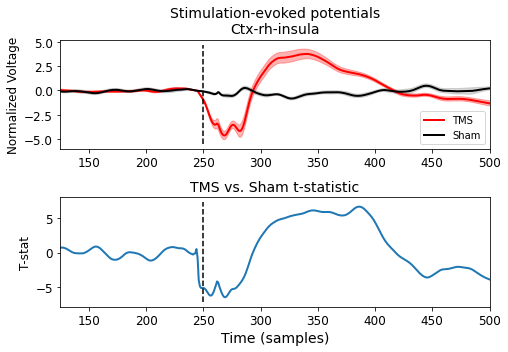

In [28]:
%matplotlib inline

#Average waveforms
sep_tms_mu = np.mean(sep_tms_, 0)
sep_sham_mu = np.mean(sep_sham_, 0)
sep_tms_sem = sem(sep_tms_, axis=0)
sep_sham_sem = sem(sep_sham_, axis=0)

# Plot some SEPs for a given electrode
e = 110
plt.figure(figsize=(7, 5))
ax = plt.subplot(211)
plt.fill_between(x = np.arange(sep_tms_mu[e, :].size), y1=sep_tms_mu[e, :]-sep_tms_sem[e, :], 
                 y2 = sep_tms_mu[e, :]+sep_tms_sem[e, :], color='red', alpha=0.3)  #plot the error bars
plt.fill_between(x = np.arange(sep_sham_mu[e, :].size), y1=sep_sham_mu[e, :]-sep_sham_sem[e, :], 
                 y2 = sep_sham_mu[e, :]+sep_sham_sem[e, :], color='gray', alpha=0.3)
plt.plot(sep_tms_mu[e, :], color='r', linewidth=2, label='TMS');
plt.plot(sep_sham_mu[e, :], color='k', linewidth=2, label='Sham');
plt.vlines([250], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='k', linestyle='--')
plt.xlim(125,500); 
plt.xticks(fontsize=12); plt.yticks(fontsize=12); plt.ylabel('Normalized Voltage', fontsize=12)
plt.legend(loc=4)
plt.title('Stimulation-evoked potentials\n'+elecs.iloc[e]['DKT_label'], fontsize=14)

ax = plt.subplot(212)
plt.plot(ttest_ind(sep_tms_[:, e, :], sep_sham_[:, e, :], axis=0, equal_var=True)[0], linewidth=2)
plt.vlines([250], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='k', linestyle='--')
plt.title('TMS vs. Sham t-statistic', fontsize=14); plt.ylabel('T-stat', fontsize=12)
plt.xlim(125,500); 
plt.xticks(fontsize=12); plt.yticks(fontsize=12); plt.xlabel('Time (samples)', fontsize=14)
plt.tight_layout()

## Identify saturated channels

In [18]:
minmax_ts = []
for e in range(sep_tms_.shape[1]):
    t, p = ttest_ind(sep_tms_[:, e, :], sep_sham_[:, e, :], axis=0, equal_var=True)
    t = np.abs(t)
    minmax_ts.append(max(t))
sat_chans = np.where(np.array(minmax_ts)>10)[0]
print('Saturated channels: '+str(sat_chans))

# Better approach is to look for >10 normalized voltage relative to pre-stim period in each trial. 
sat_comb = list(zip(np.where(np.abs(sep_tms_)>10)[0], np.where(np.abs(sep_tms_)>10)[1]))
unique_sat_combs = np.unique([str(f) for f in sat_comb]) # ordered as trial, elec
B = [(int(s.split(', ')[0][1:]), int(s.split(', ')[1][0:-1])) for s in unique_sat_combs] # string thing is a quick hack! 
bad_elecs, cts = np.unique([b[1] for b in B], return_counts=True)
bad_elecs_remove = bad_elecs[cts>(0.1*sep_tms_.shape[0])]

# Consider excluding any electrode with >10% of trials contaminated.
# For others, remove the contaminated trials and continue using the elec

Saturated channels: [62 63]


* Subject 430, parahippocampal stim, elec 46 (hippocampus) seems to have a nice phase-locking type of response
* Subject 430, parahippocampal stim, elec 18 (right lingual gyrus) and 35 (supramarginal) also shows nice phase-locking
* Subject 477, parietal stim, elec 28 (L lingual gyrus) has nice evoked potential response
* Subject 477, parietal stim, elec 106 (superior parietal) has possible artifact response
* Subject 477, parietal stim, has a high-frequency artifact contaminating many sham trials at 1300ms post-stim
* Subject 477, parietal stim, elec 104 has a large theta response but also a significant evoked potential on a subset of trials (also shows good phase locking). 
* Subject 477, DLPFC stim, has anomalies with the data (timing error?)
* Subject 518, DLPFC stim, has a nice hippocampal evoked potential at the 200ms post-stim mark in (hippocampal) elec 1
* Subject 518, DLPFC stim, has potentiall some nice phase-locking effects in hippocampus, too. 
* Subject 561 has several issues, including missing data in several channels and likely artifact/saturation in many others
* Subject 460, the "cleaned" data appears to not have been cleaned in any appreciable way (TMS artifact still present). 

Effective window size : 0.512 (s)


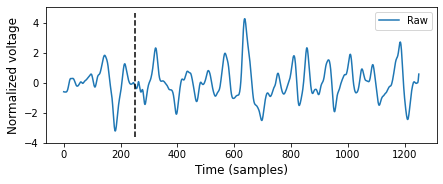

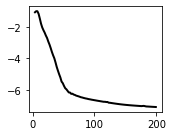

In [21]:
from codebase import butter_bandpass_filter

### Example traces
plt.figure(figsize=(7, 2.5))
ax=plt.subplot(111)
trial = 27
X = sep_sham_[trial, e, :]  #trials, elecs, time
plt.plot(X,  label='Raw')
plt.vlines([250], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='k', linestyle='--')

#from codebase import butter_bandpass_filter
# plt.plot(butter_bandpass_filter(X, 3., 5., fs=fs, order=1), color='C3', linewidth=2, label='Theta')
# plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.xlabel('Time (samples)', fontsize=12); plt.ylabel('Normalized voltage', fontsize=12)
plt.legend()

#Check power spectrum
from mne.time_frequency import psd_array_welch
psd, freqs = psd_array_welch(sep_tms_[:, e, :], sfreq=fs, fmin=3, fmax=200)
plt.figure(figsize=(2.5, 2)); 
plt.plot(freqs, np.mean(np.log10(psd), 0), linewidth=2, color='k')
plt.tight_layout()

## Get spectral power
Compute multitaper power from the 1.5-second interval following stimulation with 50ms buffer from stimulatione event itself

In [38]:
freqs = [3, 4, 5, 6, 7, 8]  # theta
#freqs = [30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50] #gamma
#freqs = [70, 75, 80, 85, 90, 95] # high gamma
#endtime = 2050

#Get the X-second window with a 50ms buffer from stim period -- TMS trials
tfr_tms_pow = mne.time_frequency.tfr_array_multitaper(sep_tms_[:, :, :], sfreq=fs, freqs=freqs, output='power',
                                                  n_cycles=1, time_bandwidth=4, n_jobs=n_cpus)
tfr_tms_pow = np.log10(tfr_tms_pow)

# Now for the sham trials
tfr_sham_pow = mne.time_frequency.tfr_array_multitaper(sep_sham_[:, :, :], sfreq=fs, freqs=freqs, output='power',
                                                  n_cycles=1, time_bandwidth=4, n_jobs=n_cpus)
tfr_sham_pow = np.log10(tfr_sham_pow)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=8)]: Done 154 tasks      | elapsed:   11.2s
[Parallel(n_jobs=8)]: Done 225 out of 225 | elapsed:   15.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 104 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 218 out of 225 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done 225 out of 225 | elapsed:    4.3s finished


### Power analysis (timecourse)

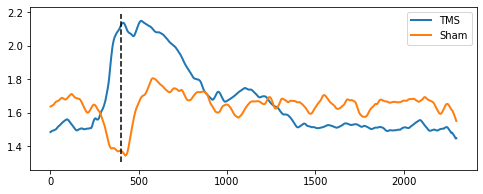

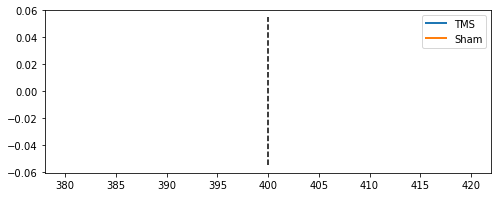

In [39]:
e = 1

plt.figure(figsize=(8, 3)); ax=plt.subplot(111)

avg_tms_pow_trial = np.mean(tfr_tms_pow[:, :, :, 100:-100], 0)
avg_tms_pow_freq = np.mean(avg_tms_pow_trial, 1) #average over trials and frequencies

avg_sham_pow_trial = np.mean(tfr_sham_pow[:, :, :, 100:-100], 0)
avg_sham_pow_freq = np.mean(avg_sham_pow_trial, 1) #average over trials and frequencies

# Only for the specified electrode
plt.plot(avg_tms_pow_freq[e, :], linewidth=2, label='TMS')
plt.plot(avg_sham_pow_freq[e, :], linewidth=2, label='Sham')
plt.vlines([400], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='k', linestyle='--')
plt.legend()

# Averaged over whole brain
plt.figure(figsize=(8, 3)); ax=plt.subplot(111)
plt.plot(np.mean(avg_tms_pow_freq[:, :], 0), linewidth=2, label='TMS')
plt.plot(np.mean(avg_sham_pow_freq[:, :], 0), linewidth=2, label='Sham')
plt.vlines([400], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='k', linestyle='--')
plt.legend()

### Power analysis (trial-averaged)

In [27]:
from mne.time_frequency import psd_array_multitaper

freqs = [3, 8]  # theta
#freqs = [70, 95] # high gamma
#freqs = [30, 50] #gamma

# Set some params
starttime = 600
endtime = starttime+1500


psd_tms, freqs_used = psd_array_multitaper(sep_tms_[:, :, starttime:endtime], sfreq=fs, fmin = freqs[0], fmax=freqs[1], 
                               output='power', verbose=False, n_jobs=n_cpus)
psd_sham, freqs_used = psd_array_multitaper(sep_sham_[:, :, starttime:endtime], sfreq=fs, fmin = freqs[0], fmax=freqs[1], 
                               output='power', verbose=False, n_jobs=n_cpus)
psd_tms = np.log10(psd_tms); psd_sham = np.log10(psd_sham)

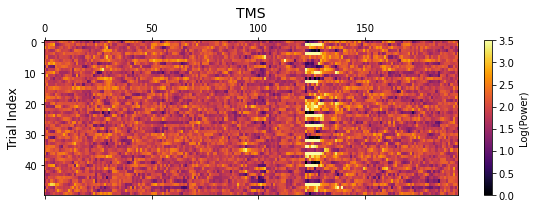

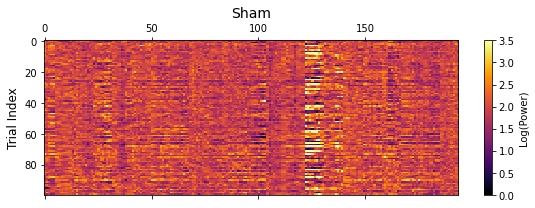

In [28]:
plt.figure(figsize=(8, 3))
plt.matshow(np.mean(psd_tms, 2), cmap='inferno', fignum=0, aspect='auto', vmin=0, vmax=3.5)
plt.ylabel('Trial Index', fontsize=12)
cbar = plt.colorbar(); cbar.set_label('Log(Power)')
plt.title('TMS', fontsize=14)
plt.tight_layout()

plt.figure(figsize=(8, 3))
plt.matshow(np.mean(psd_sham, 2), cmap='inferno', fignum=0, aspect='auto', vmin=0, vmax=3.5)
plt.ylabel('Trial Index', fontsize=12)
cbar = plt.colorbar(); cbar.set_label('Log(Power)')
plt.title('Sham', fontsize=14)
plt.tight_layout()

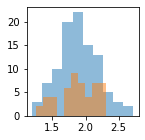

In [54]:
plt.figure(figsize=(2, 2))
plt.hist(np.mean(psd_sham, 2)[:, 46], alpha=0.5);
plt.hist(np.mean(psd_tms, 2)[:, 46], alpha=0.5);

(array([], dtype=int64),)


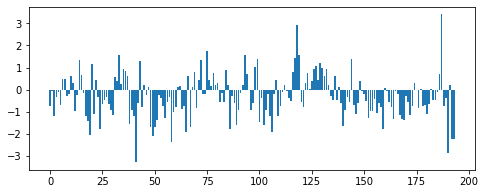

In [55]:
%matplotlib inline

#Plot results
t, p = ttest_ind(np.mean(psd_tms, 2), np.mean(psd_sham, 2), axis=0, equal_var=False)
plt.figure(figsize=(8, 3))
plt.bar(np.arange(t.size), t)

#FDR correction for significance
from mne.stats import fdr_correction
b, p_corr = fdr_correction(p, 0.05, method='indep')
print(np.where(b))

#### How does buffer time from stim affect spectral results?

In [59]:
from scipy.stats import pearsonr

freqs = [5, 8]
starttimes = np.arange(0, 2001, 200)

psds_tms = [];

for s in starttimes:
    #Get spectral powers
    psd_tms, freqs_used = psd_array_multitaper(sep_tms_[:, :, s:s+200], sfreq=fs, fmin = freqs[0], fmax=freqs[1], 
                                   output='power', verbose=False, n_jobs=n_cpus)
    psd_tms = np.log10(np.mean(psd_tms, 2))  #output is trials x chans
    
    #Get correlations
    psds_tms.append(psd_tms);

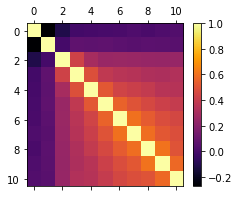

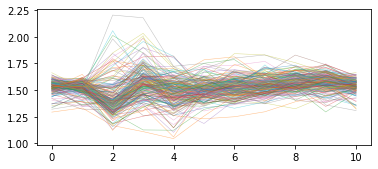

In [61]:
# See how well powers correlate as the stim buffer is progressively widened
corrs = np.corrcoef(np.array([p_.ravel() for p_ in psds_tms]))

plt.figure(figsize=(3.5, 3)); ax=plt.subplot(111)
plt.matshow(corrs, fignum=0, aspect='auto', cmap='inferno')
plt.colorbar()

# See what a typical power timecourse looks like (in the averaged 200ms bins)
plt.figure(figsize=(6, 2.5))
toplot = np.mean(np.array(psds_tms), 1)
plt.plot(toplot, alpha=0.5, linewidth=0.5);
#plt.xlim(3, 10)

### Phase-locking analysis

In [58]:
freqs = [3, 4, 5, 6, 7, 8]  # theta
#freqs = [70, 75, 80, 85, 90, 95] # high gamma
#freqs = [30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50] #gamma

# Need to subsample to smallest number of trials between TMS and sham (usually TMS), because
# ITC is affected by trial count
mintrials = np.min([sep_tms_.shape[0], sep_sham_.shape[0]])

#Get the X-second window with a 50ms buffer from stim period -- TMS trials
tfr_tms = mne.time_frequency.tfr_array_multitaper(sep_tms_[np.random.choice(sep_tms_.shape[0], mintrials, replace=False), :, :], 
                                                  sfreq=fs, freqs=freqs, output='itc',
                                                  n_cycles=1, time_bandwidth=4, n_jobs=n_cpus)

# Now for the sham trials
tfr_sham = mne.time_frequency.tfr_array_multitaper(sep_sham_[np.random.choice(sep_sham_.shape[0], mintrials, replace=False), :, :],
                                                   sfreq=fs, freqs=freqs, output='itc',
                                                  n_cycles=1, time_bandwidth=4, n_jobs=n_cpus)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done  88 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done 194 out of 194 | elapsed:    6.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 120 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 194 out of 194 | elapsed:    3.5s finished


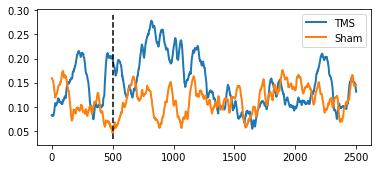

In [68]:
e = 3

plt.figure(figsize=(6, 2.5)); ax=plt.subplot(111)
plt.plot(np.mean(tfr_tms[e, :, :], 0), linewidth=2, label='TMS')
plt.plot(np.mean(tfr_sham[e, :, :], 0), linewidth=2, label='Sham')
plt.vlines([500], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='k', linestyle='--')
plt.legend()